In [166]:
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum")  # Or other appropriate channel

backend_name ='ibm_brisbane'
backend = service.backend(backend_name)

import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from qiskit_aer import Aer
from qiskit.compiler import transpile


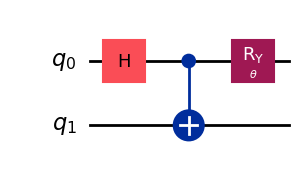

In [167]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel = 'ibm_quantum',token='fa6c1fd6e1d33ed21b09389e84015f16788b8ee7de800ce4a5a1f8b9c934b9cc0f145a64f9926598c14a798763f1eb58e389d6a1cfa6f143a2f8dc8271b7faa2'
)
theta = Parameter("$\\theta$")
qc = QuantumCircuit(2)
qc.h(0)  #Create a h gate on the 0 quibit
qc.cx(0, 1)  #Create a CNOT gate on 0 and 1
qc.ry(theta, 0)
#qc.cry(-2 * theta, 0, 1)
qc.draw(output = 'mpl')

In [168]:
number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]
print (phases)

[0.         0.31415927 0.62831853 0.9424778  1.25663706 1.57079633
 1.88495559 2.19911486 2.51327412 2.82743339 3.14159265 3.45575192
 3.76991118 4.08407045 4.39822972 4.71238898 5.02654825 5.34070751
 5.65486678 5.96902604 6.28318531]


In [169]:


# <CHSH1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>
observable1 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)])

# <CHSH2> = <AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>
observable2 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)])

from qiskit_aer import AerSimulator

simulator = AerSimulator()

chsh_isa_circuit = transpile(qc, backend=simulator, optimization_level=3)
chsh_isa_circuit.draw(output="mpl", idle_wires=False, style="iqp")


isa_observable1 = observable1.apply_layout(layout=chsh_isa_circuit.layout)
isa_observable2 = observable2.apply_layout(layout=chsh_isa_circuit.layout)


# To run on a local simulator:
# Use the StatevectorEstimator from qiskit.primitives instead.
Obv1_ZZ=(isa_observable1[0])
Obv1_ZX=(isa_observable1[1])
Obv1_XZ=(isa_observable1[2])
Obv1_XX=(isa_observable1[3])

Obv2_ZZ=(isa_observable2[0])
Obv2_ZX=(isa_observable2[1])
Obv2_XZ=(isa_observable2[2])
#print(isa_observable2[2])
Obv2_XX=(isa_observable2[3])




In [ ]:
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()

job_1 = estimator.run([(chsh_isa_circuit, [[Obv1_ZZ], [Obv1_ZX], [Obv1_XZ], [Obv1_XX], [Obv2_ZX], [Obv2_XZ]], phases)])


result_1 = job_1.result()



# Check the status
print(job_1.status())



JobStatus.DONE
JobStatus.DONE
Job Result: PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(6, 21), dtype=float64>), stds=np.ndarray(<shape=(6, 21), dtype=float64>), shape=(6, 21)), metadata={'target_precision': 0.0, 'circuit_metadata': {}})], metadata={'version': 2})


In [181]:
ab = result_1[0].data.evs[0]
minus_aB = result_1[0].data.evs[1] #Mayus stand for prime
Ab = result_1[0].data.evs[2]
AB = result_1[0].data.evs[3]

aB = result_1[0].data.evs[4]
minus_Ab = result_1[0].data.evs[5]

S_1= ab+minus_aB+Ab+AB

S_2= ab+aB+minus_Ab+AB


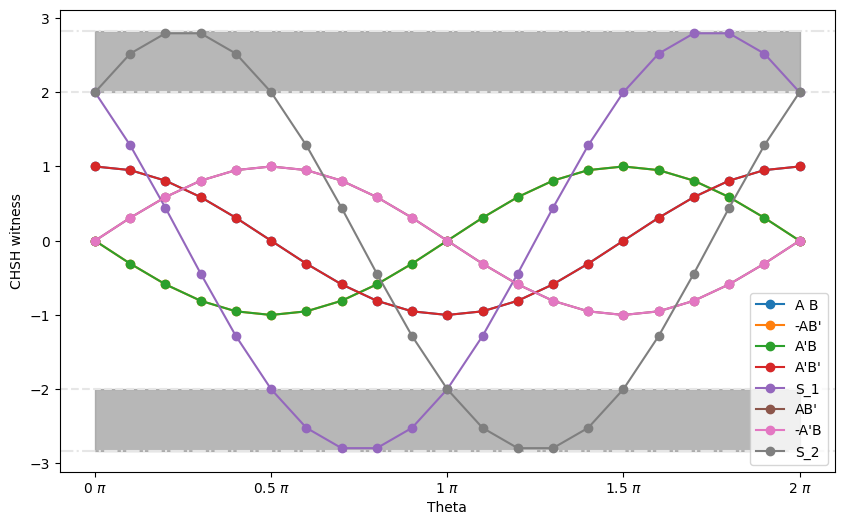

In [182]:
from sympy import symbols
fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, ab, "o-", label="A B", zorder=3)
ax.plot(phases / np.pi, minus_aB, "o-", label="-AB'", zorder=3)
ax.plot(phases / np.pi, Ab, "o-", label="A'B", zorder=3)
ax.plot(phases / np.pi, AB, "o-", label="A'B'", zorder=3)
ax.plot(phases / np.pi, S_1, "o-", label="S_1", zorder=3)

#ax.plot(phases / np.pi, chsh1_est_ZZ, "o-", zorder=3) #label="chsh1_est_ZZ"
ax.plot(phases / np.pi, aB, "o-", label="AB'", zorder=3)
ax.plot(phases / np.pi, minus_Ab, "o-", label="-A'B", zorder=3)
#gax.plot(phases / np.pi, chsh1_est_XX, "o-", zorder=3) #label="chsh1_est_XX",
ax.plot(phases / np.pi, S_2, "o-", label="S_2", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()

In [173]:
print(chsh_isa_circuit)

     ┌───┐     ┌──────────────┐
q_0: ┤ H ├──■──┤ Ry($\theta$) ├
     └───┘┌─┴─┐└──────────────┘
q_1: ─────┤ X ├────────────────
          └───┘                
